# Importing/Loading

In [1]:
!pip install transformers

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from nltk.tokenize import TweetTokenizer, word_tokenize
from collections import defaultdict
import re
import nltk
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import numpy as np


nltk.download('punkt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("week-dataset.csv")
col_titles = df.columns.values
# df

# BiLSTM module defintion

In [4]:
class biLSTM(nn.Module):

    def __init__ (self, h_dim = 10, e_dim = 10, lstm_layers = 1, dropout_rate = 0.2):
        super(biLSTM, self).__init__()
        
        self.h_dim = h_dim
        self.e_dim = e_dim
        self.embedding = nn.Embedding(num_embeddings= len(word2ind) + 1, embedding_dim = self.e_dim, padding_idx = 0)
        self.pool = torch.nn.AdaptiveAvgPool1d(output_size=1)

        self.lstm = nn.LSTM(input_size = self.e_dim, 
                            hidden_size = self.h_dim, 
                            num_layers = lstm_layers,
                            batch_first = True,
                            bidirectional = True)
        
        self.drop = nn.Dropout(p = dropout_rate)
        self.linear = nn.Linear(2 * self.h_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X):

        X = self.embedding(X)
        X = self.drop(X)
        X, _ = self.lstm(X)
        X = X.permute(0,2,1)
        X = self.pool(X)
        X = torch.squeeze(X)
        X = self.linear(X)       
        X = self.sigmoid(X)

        return X

In [6]:
lstm = torch.load("biLSTM_nltk.pt")
# t = torch.tensor([1., 2.])
# torch.save(t, 'tensor.pt')
# torch.load('tensor.pt')

In [7]:
lstm

biLSTM(
  (embedding): Embedding(24240, 10, padding_idx=0)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (lstm): LSTM(10, 10, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# BiLSTM Tokenizer

In [12]:
def findUrl(string):
  
    # findall() has been used 
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    found = re.search(regex, string)
    return found

In [13]:
train_data = df
tokenizer = TweetTokenizer()

Xs = []

for col_title in col_titles:
    hashtag = True
    wordcount = defaultdict(int)
    # vocab_size = 500

    lines = []
    maxlen = 0

    for data in train_data[col_title]:

        line = []

        tokens = tokenizer.tokenize(data.lower())

        for token in tokens:
            url = findUrl(token)
            if url:
                line.append('<URL>')
                wordcount['<URL>'] += 1
            elif token[0] == '#':
                if hashtag:
                    line.append(token[1:])
                    wordcount[token[1:]] += 1
                else:
                    line.append('<HASH>')
                    wordcount['<HASH>'] += 1
            else:
                more_words = word_tokenize(token)
                for w in more_words:
                    line.append(w)
                    wordcount[w] += 1

        # line.append('<END>')
        maxlen = max(maxlen, len(line))
        lines.append(line)

    # wordcount['<START>'] = len(train_data['Tweet'])
    # wordcount['<END>'] = len(train_data['Tweet'])

    sorted_wordcounts = sorted(wordcount.items(), key = lambda item: item[1], reverse=True)

    word2ind = {}
    ind2word = {}

    ind = 1
    # for k, v in sorted_wordcounts[:vocab_size - 1]:
    #     word2ind[k] = ind
    #     ind2word[ind] = k
    #     ind += 1

    # for k, v in sorted_wordcounts[vocab_size - 1:]:
    #     word2ind[k] = vocab_size
    #     ind2word[vocab_size - 1] = '<UKN>'

    for k, v in sorted_wordcounts:
        word2ind[k] = ind
        ind2word[ind] = k
        ind += 1

    X = []

    for line in lines:
        ind_line = []
        for word in line:
            ind_line.append(word2ind[word])
        
        if len(ind_line) < maxlen:
            ind_line += [0] * (maxlen - len(ind_line))
        
        X.append(ind_line)

    Xs.append(X)
    # len(word2ind)

KeyboardInterrupt: ignored

# BERT

In [4]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [5]:
class SMSCollectionDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        # print("Getting item", i)
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

In [6]:
def create_data_loader(df, tokenizer, max_len, batch_size, col_title):
    # print("msgs", df[col_title].to_numpy())
    ds = SMSCollectionDataset(
        spam=np.zeros(df[col_title].to_numpy().shape[0]),
        msgs=df[col_title].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16

data_loaders = []
for col_title in col_titles:
    data_loaders.append(create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE, col_title))




msgs ["New Video BIG NEWS! JohnnyDepp's side RESTS, Amber Heard To Take The Stand https://t.co/LTMkuonlph via @YouTube @nerdlecca"
 'Judge denies Amber Heard bid to dismiss Johnny Depp defamation suit - The Independent https://t.co/7keVmj8pHd'
 'The fact that most women stand with  #JohnnyDepp instead of Amber Heard speaks volumes.'
 'Judge denies Amber Heard bid to dismiss Johnny Depp defamation suit - The Independent 😡😡😡the plot thickens  https://t.co/UXXrPBSAjP'
 "Johnny Depp just spent 3 weeks painting Amber Heard as manipulative and abusive. Now it's time for Heard to tell her side of the story. https://t.co/LyPnuBfTmK"
 "Never forget..... \nJohnny Depp requested this trial be public.\nAmber Heard fought it. \n\nWonder why? \nEven Obama's PR firm couldn't help her. \n#JusticeForJohnnyDepp \n#MePoo\nShe has insulted actual DV victims and owes them an apology."
 'Amber Heard? No comment.\n\nThese things always surface eventually.\n\nAbusers and their reputations tend to live on borr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
model = SpamClassifier(n_classes=2)
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Bert Evaluation

In [16]:
# data_loaders

In [9]:
# next(iter(data_loaders[0]))
# d = next(iter(data_loaders[0]))
# d.keys()

Ys = []
# for data_loader in data_loaders:
data_loader = data_loaders[0]
Y = []
for d in data_loader:
    print("d", d)
    print("inpts", d['input_ids'].to(device))
    Y.append(model(input_ids=d['input_ids'].to(device), attention_mask=d['attention_mask'].to(device)))
Ys.append(Y)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

d {'msg': ["New Video BIG NEWS! JohnnyDepp's side RESTS, Amber Heard To Take The Stand https://t.co/LTMkuonlph via @YouTube @nerdlecca", 'Judge denies Amber Heard bid to dismiss Johnny Depp defamation suit - The Independent https://t.co/7keVmj8pHd', 'The fact that most women stand with  #JohnnyDepp instead of Amber Heard speaks volumes.', 'Judge denies Amber Heard bid to dismiss Johnny Depp defamation suit - The Independent 😡😡😡the plot thickens  https://t.co/UXXrPBSAjP', "Johnny Depp just spent 3 weeks painting Amber Heard as manipulative and abusive. Now it's time for Heard to tell her side of the story. https://t.co/LyPnuBfTmK", "Never forget..... \nJohnny Depp requested this trial be public.\nAmber Heard fought it. \n\nWonder why? \nEven Obama's PR firm couldn't help her. \n#JusticeForJohnnyDepp \n#MePoo\nShe has insulted actual DV victims and owes them an apology.", 'Amber Heard? No comment.\n\nThese things always surface eventually.\n\nAbusers and their reputations tend to live on

KeyboardInterrupt: ignored

# Prediction

In [38]:
Ys = []
for X in Xs:
    X = torch.tensor(X, device = device)
    Ys.append(lstm(X))


In [61]:
arr = [(Ys[i] > .5).int().cpu().numpy() for i in range(len(Xs))]
# print(len(arr))
# print(arr[0])
# print(arr.sum() / len(arr))

5


# Vis

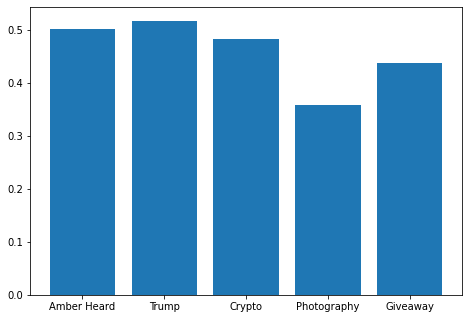

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cols = ['Amber Heard', "Trump", "Crypto", "Photography", "Giveaway"]
students = [a.sum() / len(a) for a in arr]
ax.bar(cols,students)
plt.show()